In [1]:
cd ..

/home/sam/cc-net


/home/sam/anaconda3/envs/primal-dual/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import graphlearning as gl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import torch
import scipy.sparse as sp
from scipy.sparse import coo_matrix, triu

import yaml
import models.models as Models
import losses.losses as Losses
import datasets.datasets as Datasets

from tqdm.notebook import tqdm

In [3]:
def plot_graph(X, edge_index, ax):
    for i, j in zip(edge_index[0], edge_index[1]):
        ax.plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], color='0.8', alpha=0.8, zorder=1) 
    ax.scatter(X[:, 0], X[:, 1], edgecolors='none', color='red', zorder=2)

In [4]:
def visualize_clusters(X, U, ax, point_size=8, label="Clustered data"):
    """Plot the loss curve and a grayscale scatter of the smoothed solution U."""
    fig = plt.figure(figsize=(10,4))
    ax.scatter(X[:, 0], X[:, 1], s=8, edgecolors='none', alpha=0.5, label='original data')
    ax.scatter(U[:,0].cpu(), U[:,1].cpu(), s=point_size, alpha=0.9, c='0.4', label=label)

In [5]:
def load_model(model_cfg, model_pth):
    model_class = getattr(Models, model_config['model'])
    model = model_class(**model_config['cfg'])
    model = model.float()
    model_state = torch.load(model_pth, map_location='cpu')
    model.load_state_dict(model_state)
    return model

def forward_pass(model, data):
    src = data.edge_index[0]
    dst = data.edge_index[1]
    e_init = data.x[src] - data.x[dst]
    h, e = model(h=data.x.float(),
                 e=e_init.float(), 
                 edge_index = data.edge_index, 
                 w=data.edge_attr,
                 x=data.x.float())
    return h.detach(), e.detach()
    
def get_primal_obj(U, data, lam):
    src = data.edge_index[0]
    dst = data.edge_index[1]
    w = data.edge_attr
    X = data.x
    return Losses.energy(U, X, src, dst, w, lam)

In [6]:
exp_file = 'configs/sweeps/change-depth-two-moons.yaml'
with open(exp_file, "r") as f:
    exp_cfg = yaml.safe_load(f)

In [7]:
import wandb
api = wandb.Api()

entity_name = "primal-dual"
project_name = "primal-dual"
sweep_id = "8ckgueuv"

sweep_path = f"{entity_name}/{project_name}/sweeps/{sweep_id}"

try:
    sweep = api.sweep(sweep_path)
except Exception as e:
    print(f"Error fetching sweep: {e}")
all_runs = sweep.runs

print(f"Found {len(all_runs)} runs in sweep {sweep_id}")

Found 10 runs in sweep 8ckgueuv


In [9]:
from train import make_modelstring
model_dictionary = {}
for run in all_runs:
    run_id = run.id
    model_config = run.config['model_config']
    processor_cfg = model_config['cfg']['processor_cfg']
    processor_cfg['cfg']['in_node_dim'] = model_config['cfg']['embedding_dim']
    processor_cfg['cfg']['in_edge_dim'] = model_config['cfg']['embedding_dim']
    processor_cfg['cfg']['lam'] =1.0
    modelstring = f"{processor_cfg['model']}/{make_modelstring(processor_cfg['cfg'])}_resid={model_config['cfg']['residual_stream']}_steps={model_config['cfg']['recurrent_steps']}_featDim={model_config['cfg']['in_node_dim']}"

    del model_config['cfg']['processor_cfg']['cfg']['in_node_dim']
    del model_config['cfg']['processor_cfg']['cfg']['in_edge_dim']
    del model_config['cfg']['processor_cfg']['cfg']['lam']
    
    model_pth = f'/data/sam/primal-dual/energy_pdg/single_knn/EncodeProcessDecode/{modelstring}/{run_id}/final.pt'
    model = load_model(model_config, model_pth)
    model_dictionary[modelstring] = model

In [10]:
# Load dataset
datapth = '/data/sam/primal-dual/data/single_knn_base=two_moons_n_samples=100_n_graphs=1_noise=0.15-train.pt'
dataset = torch.load(datapth)

In [11]:
import re
def extract_L(s: str) -> int | None:
    """
    Extract the integer immediately following 'L' in a string.
    Returns None if no such pattern is found.
    """
    m = re.search(r'_L(\d+)_', s)
    if m is None:
        return None
    return int(m.group(1))

In [12]:
layer_nums = []
primals = []
for modelname in tqdm(model_dictionary):
    model = model_dictionary[modelname]
    layer_num = extract_L(modelname)
    primal_obj = 0.0
    for data in dataset:
        h, e = forward_pass(model, data)
        nn_primal_obj = get_primal_obj(h, data, lam=1.0)
        primal_obj += nn_primal_obj
    primal_obj = primal_obj/len(dataset)
    layer_nums.append(layer_num)
    primals.append(primal_obj)
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
baseline_pth = '/data/sam/primal-dual/data/single_knn_base=two_moons_n_samples=100_n_graphs=1_noise=0.15-train.pt_lam=1.0/output-YaAW6kX9d7XWeXpZy53AZV.pt'
pdhg_result = torch.load(baseline_pth)


In [14]:
pdhg_primal_obj = np.array(pdhg_result['primal_objs'])
avg_pdhg_primal_objs = np.mean(pdhg_primal_obj, axis=0)
std_pdhg_primals_ = np.std(pdhg_primal_obj, axis=0)

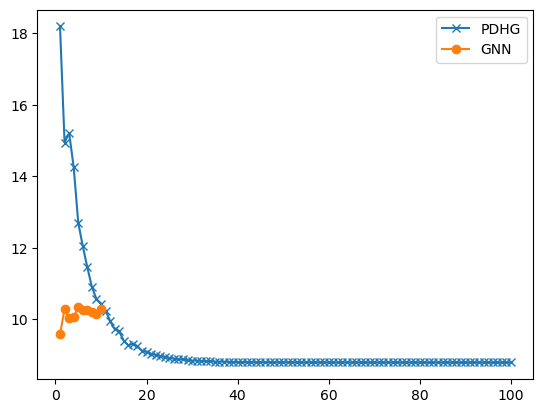

In [16]:
baseline = avg_pdhg_primal_objs[:100]
plt.plot(np.arange(1, len(baseline) + 1), baseline, marker='x', label="PDHG")
plt.plot(layer_nums, primals, marker='o', label="GNN")
plt.legend()

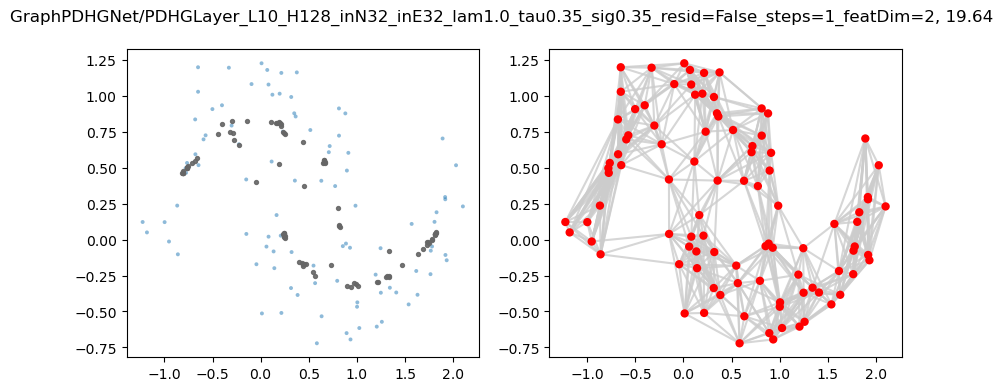

<Figure size 1000x400 with 0 Axes>

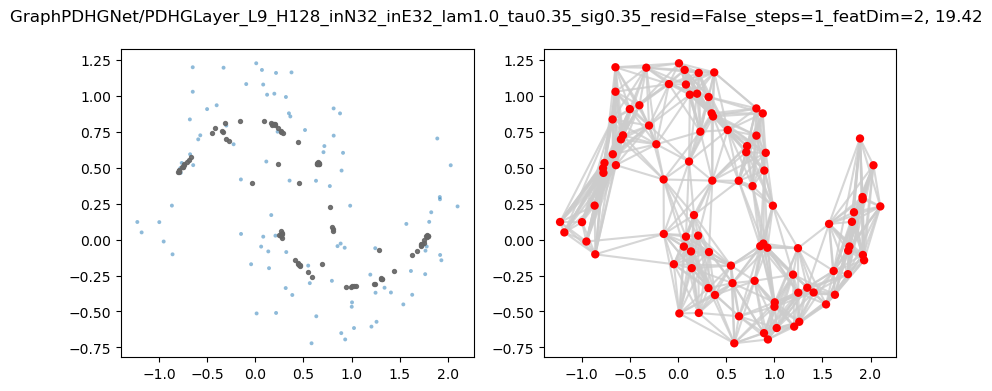

<Figure size 1000x400 with 0 Axes>

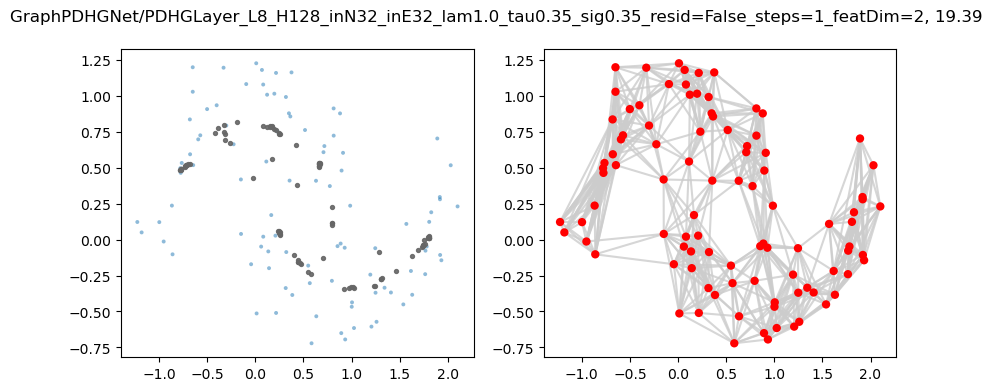

<Figure size 1000x400 with 0 Axes>

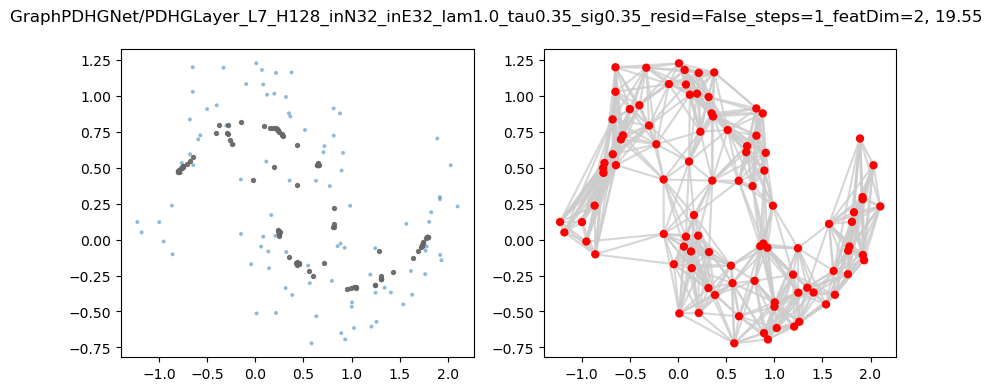

<Figure size 1000x400 with 0 Axes>

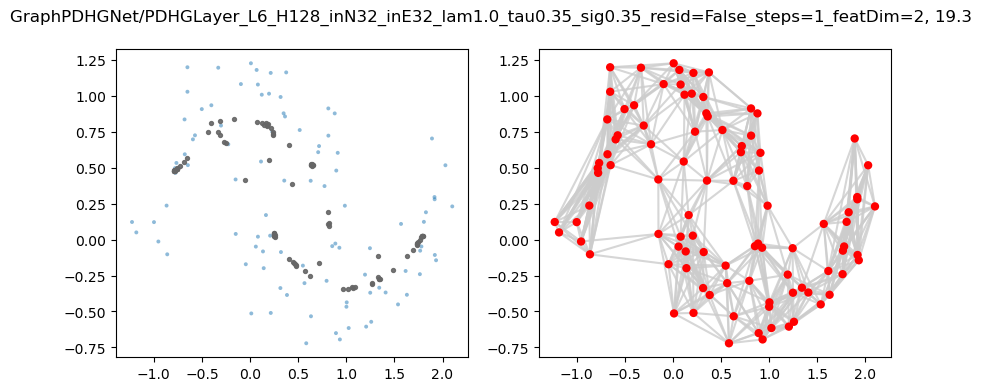

<Figure size 1000x400 with 0 Axes>

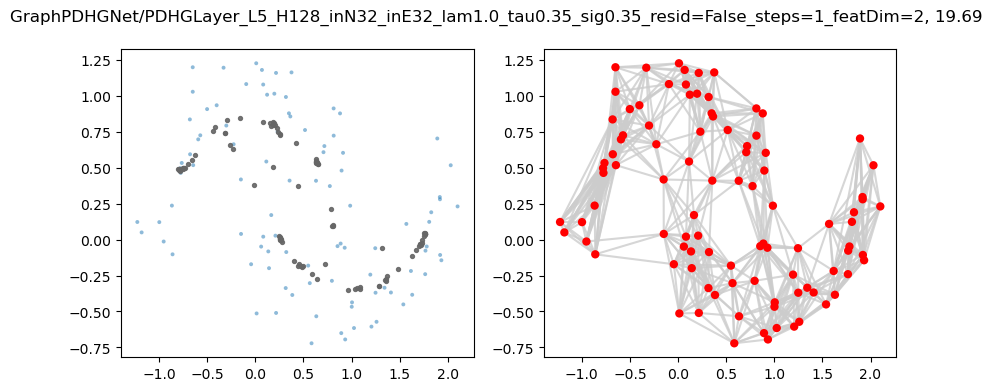

<Figure size 1000x400 with 0 Axes>

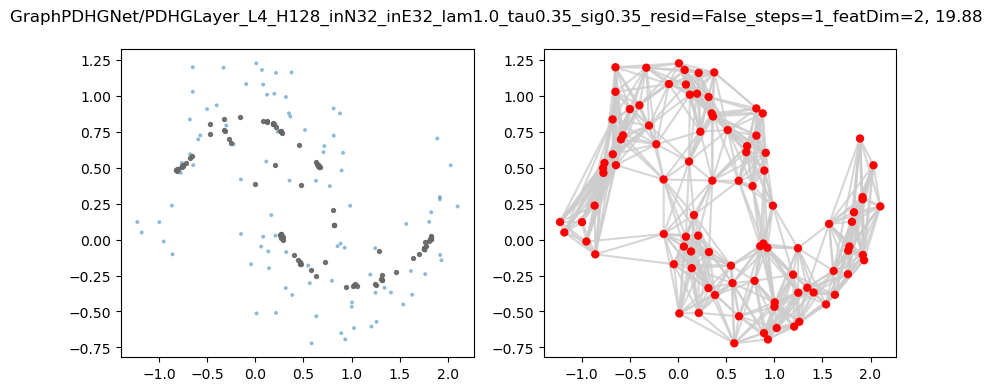

<Figure size 1000x400 with 0 Axes>

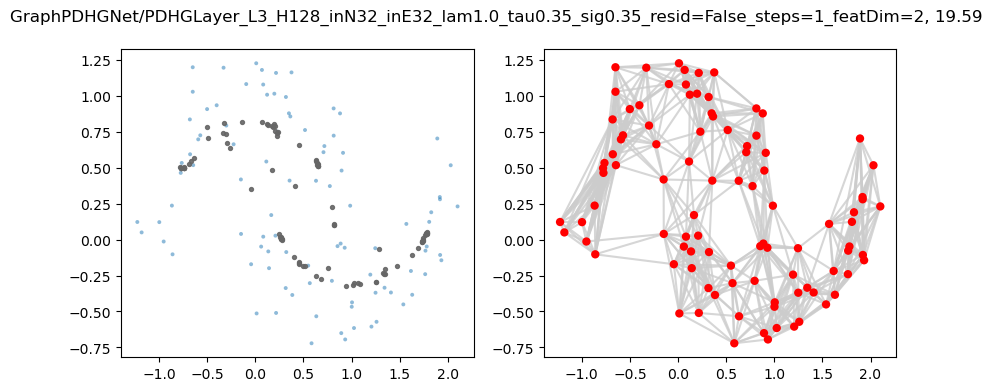

<Figure size 1000x400 with 0 Axes>

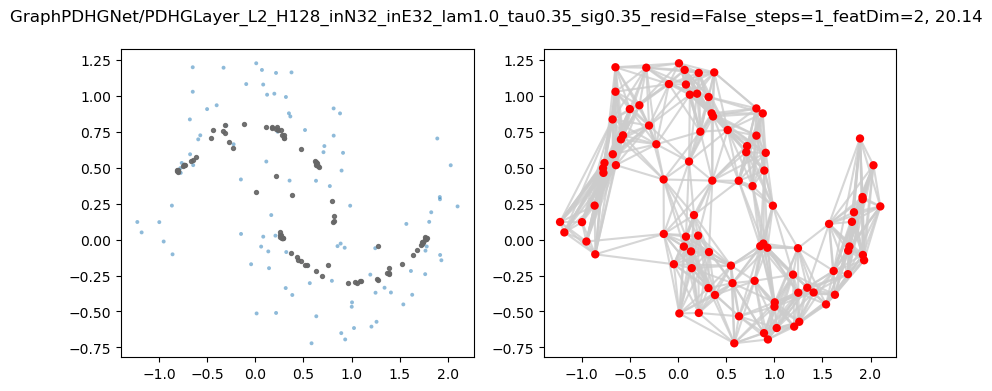

<Figure size 1000x400 with 0 Axes>

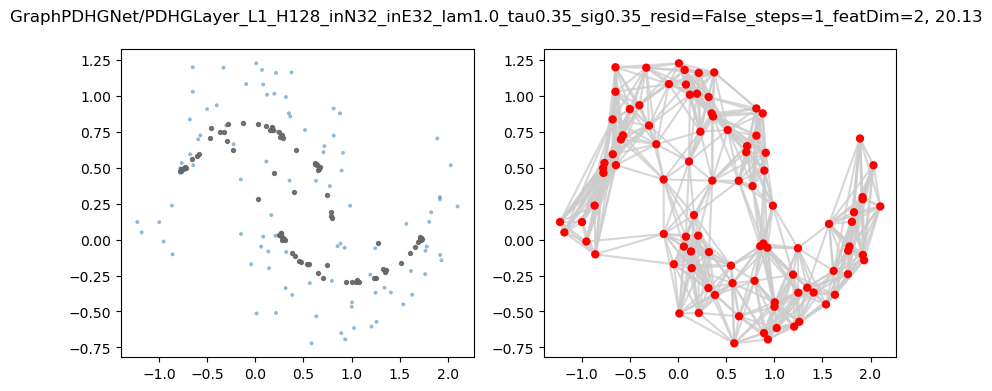

<Figure size 1000x400 with 0 Axes>

In [24]:
## Visualization
example_graph = dataset[8]
for modelname in model_dictionary:
    model = model_dictionary[modelname]
    h, e = forward_pass(model, example_graph)
    nn_primal_obj = get_primal_obj(h, example_graph, lam=1.0)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    visualize_clusters(example_graph.x, h, axs[0])
    plot_graph(example_graph.x,example_graph.edge_index, axs[1])
    fig.suptitle(f'{modelname}, {round(nn_primal_obj.item(), 2)}')

tensor(6.0257, dtype=torch.float64)


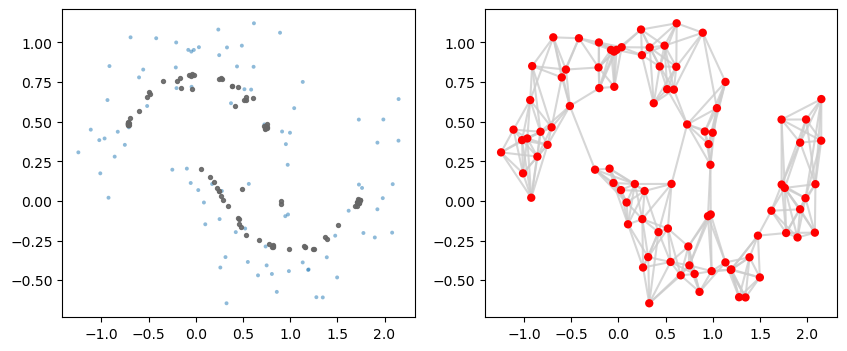

<Figure size 1000x400 with 0 Axes>

In [13]:
dataset[1].x.mean(axis=0)

tensor([0.5171, 0.2236], dtype=torch.float64)

In [14]:
## Load baseline algorithm results
pdhg_result = torch.load('/data/sam/primal-dual/baselines/gaussian_blob_dataset_n_graphs=1_min_n_nodes=100_max_n_nodes=200_n_clusters=6_k_neighbors=10_feature_dim=2-val_lam=1.0/output-C8dZ7iWweW9mRxDhTG9KFX.pt')

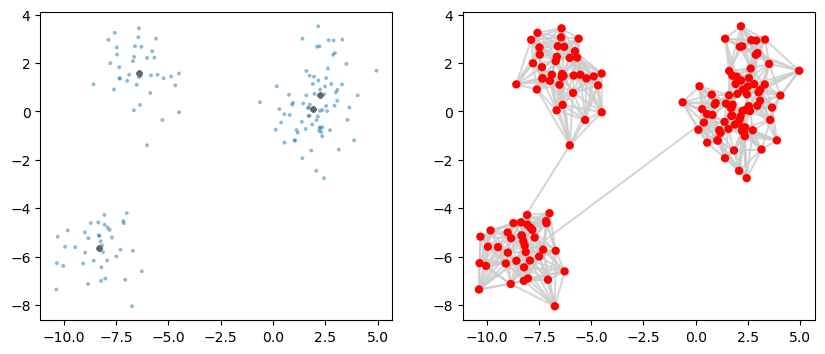

<Figure size 1000x400 with 0 Axes>

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
visualize_clusters(dataset[0].x, pdhg_result['U'][0], axs[0])
plot_graph(dataset[0].x,dataset[0].edge_index, axs[1])

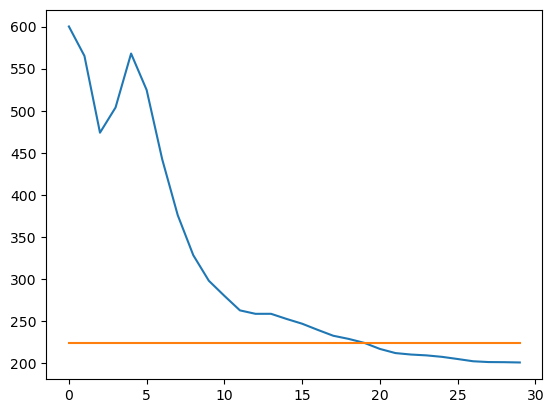

In [72]:
primal_objectives = pdhg_result['primal_objs'][0][:30]
line = np.ones(30)*224
plt.plot(np.arange(len(primal_objectives)), primal_objectives)
plt.plot(np.arange(len(primal_objectives)), line)
